In [49]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
import matplotlib.pyplot as plt
import numpy as np
import itertools 

from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

In [2]:
df_train = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2009-2010")
df_test = pd.read_excel("online_retail_II.xlsx",sheet_name="Year 2010-2011")
df_train 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [3]:
full_df = pd.concat([df_train,df_test],axis=0)

In [4]:
full_df.columns = full_df.columns.str.replace(' ','_').str.lower()

full_df['date'] = pd.to_datetime(full_df['invoicedate']).dt.date

full_df.drop(columns=['invoicedate'],inplace=True)

full_df.head()

,invoice,stockcode,description,quantity,price,customer_id,country,date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,2009-12-01


In [5]:
full_df['date'].max()

datetime.date(2011, 12, 9)

In [6]:
full_df['total'] = full_df['price'] * full_df['quantity']

agg_df = full_df.groupby(['date']).agg({'total':'sum'}).sort_values(['date'])

agg_df.head()

,total
date,
2009-12-01,53173.03
2009-12-02,62763.59
2009-12-03,68093.05
2009-12-04,40346.40
2009-12-05,9803.05


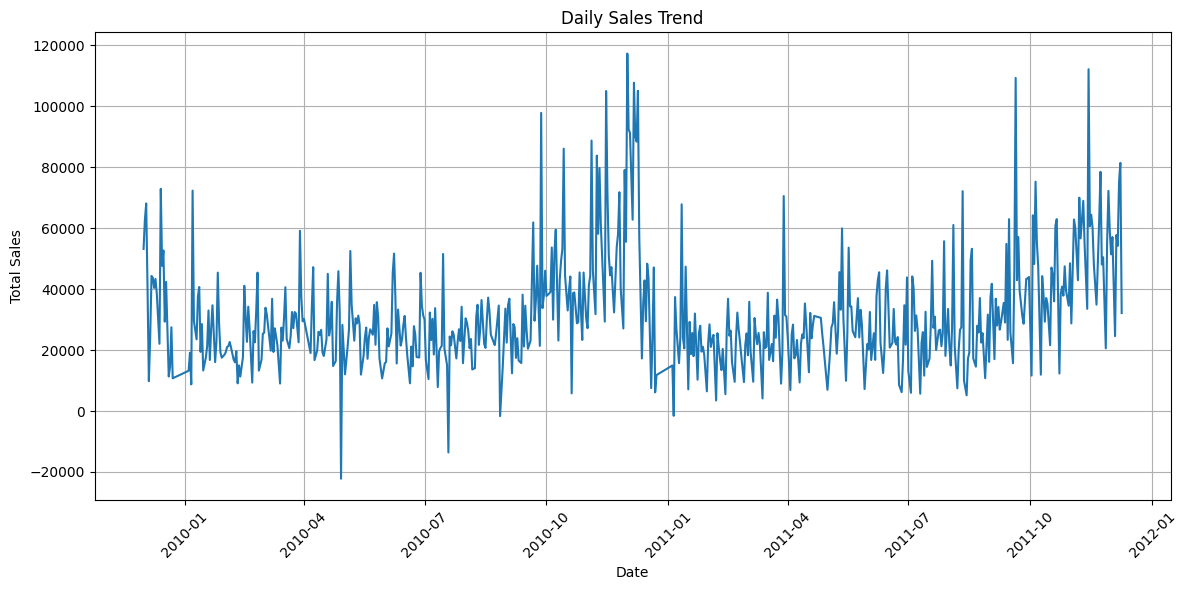

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(agg_df['total'])

plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()      
plt.show()

In [8]:
holiday = pd.DataFrame([])

uk_holidays = holidays.UK()


for date_, name in sorted(holidays.UK(years=[2010,2011,2012]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "UK-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2010-01-01,UK-Holidays,-2,1
1,2010-04-02,UK-Holidays,-2,1
2,2010-05-03,UK-Holidays,-2,1
3,2010-05-31,UK-Holidays,-2,1
4,2010-12-25,UK-Holidays,-2,1


In [17]:
df = agg_df[['total']].reset_index()
df

,date,total
0,2009-12-01,53173.03
1,2009-12-02,62763.59
2,2009-12-03,68093.05
3,2009-12-04,40346.40
4,2009-12-05,9803.05
...,...,...
599,2011-12-05,57751.32
600,2011-12-06,54228.37
601,2011-12-07,75076.22
602,2011-12-08,81417.78


In [34]:
#Variables

prediction_days = 60

forecast_start_dt = date(2011,10,1) #data set ends of (2011,12,9)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2011-10-01


In [35]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', 'total': 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date)]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

19:30:54 - cmdstanpy - INFO - Chain [1] start processing
19:30:54 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
predicted_df.head(10)

,ds,yhat
544,2011-10-01,9671.127373
545,2011-10-02,15269.378572
546,2011-10-03,30239.459620
547,2011-10-04,32317.237092
548,2011-10-05,27593.181825
549,2011-10-06,34276.506548
550,2011-10-07,25206.266110
551,2011-10-08,9547.922388
552,2011-10-09,15146.173587
553,2011-10-10,30116.254636


In [37]:
df_copy2 = df.copy()
df_copy2.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [38]:
predicted_df

,ds,yhat,y
0,2011-10-02,15269.378572,11623.58
1,2011-10-03,30239.459620,64214.78
2,2011-10-04,32317.237092,48240.84
3,2011-10-05,27593.181825,75244.43
4,2011-10-06,34276.506548,55306.28
5,2011-10-07,25206.266110,47538.02
6,2011-10-09,15146.173587,11922.24
7,2011-10-10,30116.254636,44265.89
8,2011-10-11,32194.032107,38267.75
9,2011-10-12,27469.976840,29302.85


In [39]:
def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [40]:
mape(predicted_df['y'],predicted_df['yhat'])

41.338231652106316

In [42]:
from prophet.diagnostics import cross_validation

m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m,initial = '365 days', period = '30 days', horizon = '30 days')

19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1] done processing
19:36:08 - cmdstanpy - INFO - Chain [1] start processing
19:36:08 - cmdstanpy - INFO - Chain [1]

In [47]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,5.203317e+08,22810.779539,17068.060480,2.051259,0.418056,0.498096,0.685185
1,4 days,4.634507e+08,21527.904969,16335.217869,1.912490,0.391376,0.496017,0.652778
2,5 days,3.347651e+08,18296.585805,14329.463768,0.691741,0.345956,0.442997,0.723958
3,6 days,2.760903e+08,16615.964859,12075.728664,0.662989,0.288802,0.401641,0.736111
4,7 days,3.088712e+08,17574.732088,12806.267228,0.487483,0.309772,0.395303,0.713542


In [46]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y']) * 100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y']

df_cv.sort_values('mape',ascending=False).head(10)


,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
18,2011-01-05,57986.672983,39323.957170,77476.117931,-1566.230,2011-01-03,3802.308919,True
130,2011-05-22,5326.365045,-14557.445410,24752.930003,24205.370,2011-05-03,77.995110,False
232,2011-09-20,26544.621223,5846.370464,46266.855222,109286.210,2011-08-31,75.710914,False
189,2011-07-31,8562.487701,-10092.015433,26601.661938,33486.360,2011-07-02,74.429924,False
224,2011-09-11,10501.474304,-8671.925389,28027.619908,35465.470,2011-08-31,70.389581,False
236,2011-09-25,9906.255616,-9779.397083,27865.065286,31210.921,2011-08-31,68.260291,False
183,2011-07-24,9008.507595,-9905.127900,29245.676205,26476.200,2011-07-02,65.975073,False
89,2011-03-29,25356.812487,5278.738712,45025.343296,70531.470,2011-03-04,64.048938,False
118,2011-05-08,7042.061644,-12898.905032,26251.796789,18808.920,2011-05-03,62.559989,False
199,2011-08-11,28020.128182,9375.354353,47731.061814,72132.790,2011-08-01,61.154798,False


In [50]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

19:50:25 - cmdstanpy - INFO - Chain [1] start processing
19:50:25 - cmdstanpy - INFO - Chain [1] done processing
19:50:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:50:25 - cmdstanpy - INFO - Chain [1] start processing
19:50:26 - cmdstanpy - INFO - Chain [1] done processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing
19:50:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] start processing
19:50:27 - cmdstanpy - INFO - Chain [1] done processing
19:50:27 - cmdstanpy - ERROR - Chain [1] error: error during proc

19:50:35 - cmdstanpy - INFO - Chain [1] done processing
19:50:35 - cmdstanpy - INFO - Chain [1] done processing
19:50:35 - cmdstanpy - INFO - Chain [1] done processing
19:50:36 - cmdstanpy - INFO - Chain [1] start processing
19:50:36 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] start processing
19:50:37 - cmdstanpy - INFO - Chain [1] done processing
19:50:37 - cmdstanpy - INFO - Chain [1] 

19:50:49 - cmdstanpy - INFO - Chain [1] done processing
19:50:49 - cmdstanpy - INFO - Chain [1] start processing
19:50:49 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] done processing
19:50:51 - cmdstanpy - INFO - Chain [1] start processing
19:50:51 - cmdstanpy - INFO - Chain [1]

In [51]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  21123.461161
1                     0.001                     0.10  20690.707523
2                     0.001                     1.00  20624.948420
3                     0.001                    10.00  20751.557458
4                     0.010                     0.01  17317.109883
5                     0.010                     0.10  17071.551053
6                     0.010                     1.00  17040.152809
7                     0.010                    10.00  17048.536177
8                     0.100                     0.01  21938.082618
9                     0.100                     0.10  21617.361792
10                    0.100                     1.00  21698.903391
11                    0.100                    10.00  21754.849413
12                    0.500                     0.01  22144.667185
13                    0.500                     0.10  21800.72

In [52]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])

In [53]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

19:56:17 - cmdstanpy - INFO - Chain [1] start processing
19:56:17 - cmdstanpy - INFO - Chain [1] done processing


34.682765279780554